In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Entropy

### Estimators

In [2]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.histogram import hist_entropy
from pysim.information.entropy import marginal_entropy
import time


def get_entropy_estimators(data):

    t0 = time.time()
    H_g = gauss_entropy_multi(data)
    print(f"Gaussian: {H_g:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_nbs = knn_entropy(X=data, n_neighbors=10, n_jobs=-1)
    print(f"KNN (Neighbours): {H_knn_nbs:.4f}  | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_eps = knn_entropy_npeet(X=data, n_neighbors=10, n_jobs=-1)
    print(f"KNN (epsilon): {H_knn_eps:.4f} | Time: {time.time()-t0:.4f} secs")

## Toy Data

In [3]:
n_samples = 50_000
n_features = 2
seed = 123

### Gaussian

In [4]:
from pysim.data.information.gaussian import generate_gaussian_data
from pysim.data.information.studentt import generate_studentt_data

from functools import partial

In [5]:
# create seed (trial number)
res_tuple = generate_gaussian_data(
    n_samples=n_samples, n_features=n_features, seed=seed, n_base_samples=500_000,
)
res_tuple.H

3.0226189359943914

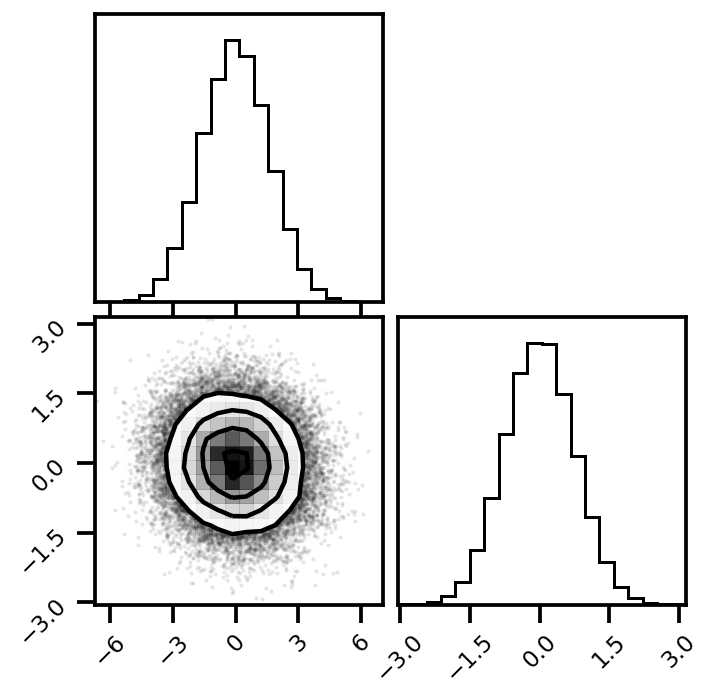

In [6]:
fig = corner.corner(res_tuple.X[:, :10])

In [7]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 3.0217 | Time: 0.0048 secs
KNN (Neighbours): 3.0218  | Time: 0.2666 secs
KNN (epsilon): 2.4740 | Time: 0.2233 secs


### Rotated Gaussian

In [8]:
from pysim.data.information.gaussian import generate_gaussian_rotation_data

In [9]:
# create marginal entropy estimator
f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt")

# create seed (trial number)
res_tuple = generate_gaussian_rotation_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=seed,
    marg_h_estimator=f,
    estimator_name="histogram",
    n_base_samples=500_000,
)

res_tuple.H

0.6475673104186844

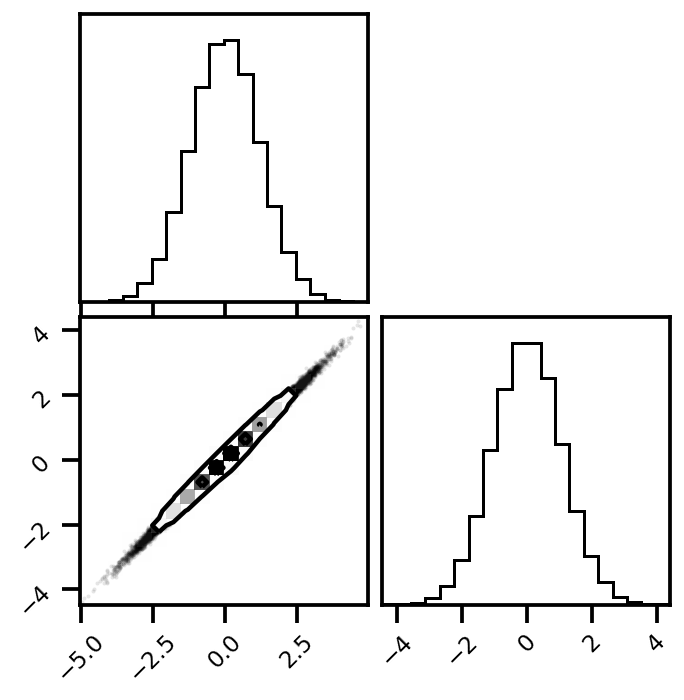

In [10]:
fig = corner.corner(res_tuple.X[:, :10])

#### Estimators

In [11]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 0.6922 | Time: 0.0030 secs
KNN (Neighbours): 0.6844  | Time: 0.2967 secs
KNN (epsilon): 1.0253 | Time: 0.2334 secs


### Uniform + Linear Rotation

In [12]:
from pysim.data.information.linear import generate_linear_entropy_data

In [13]:
# create marginal entropy estimator
f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt")

# create seed (trial number)
res_tuple = generate_linear_entropy_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=seed,
    marg_h_estimator=f,
    estimator_name="histogram",
    n_base_samples=500_000,
)

res_tuple.H

2.3536478920360056

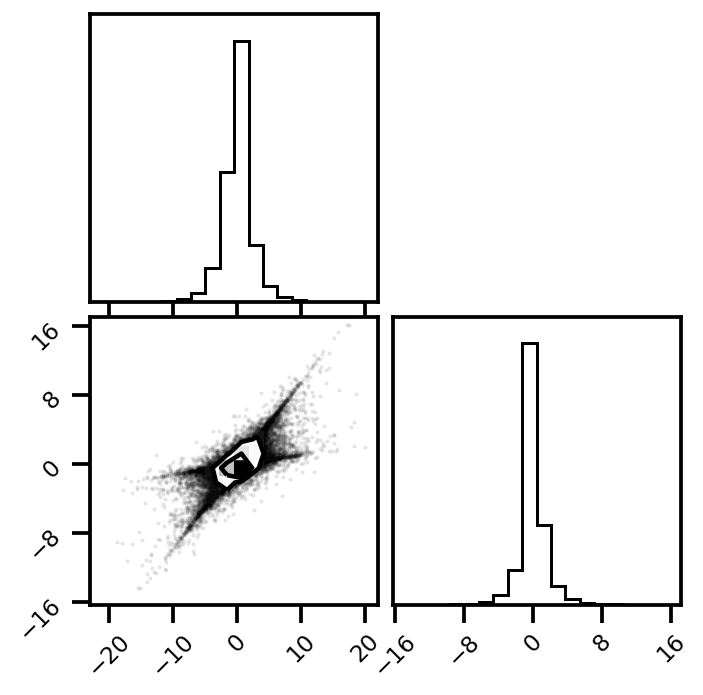

In [14]:
fig = corner.corner(res_tuple.X[:, :10])

### Estimators

In [17]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 3.7915 | Time: 0.0041 secs
KNN (Neighbours): 2.6766  | Time: 0.2570 secs
KNN (epsilon): 2.7663 | Time: 0.2280 secs


### T-Student

In [44]:
# create seed (trial number)
df = 10.0
res_tuple = generate_studentt_data(
    n_samples=n_samples,
    n_features=n_features,
    df=df,
    seed=seed,
    n_base_samples=500_000,
)
res_tuple.H

2.9994753846801827

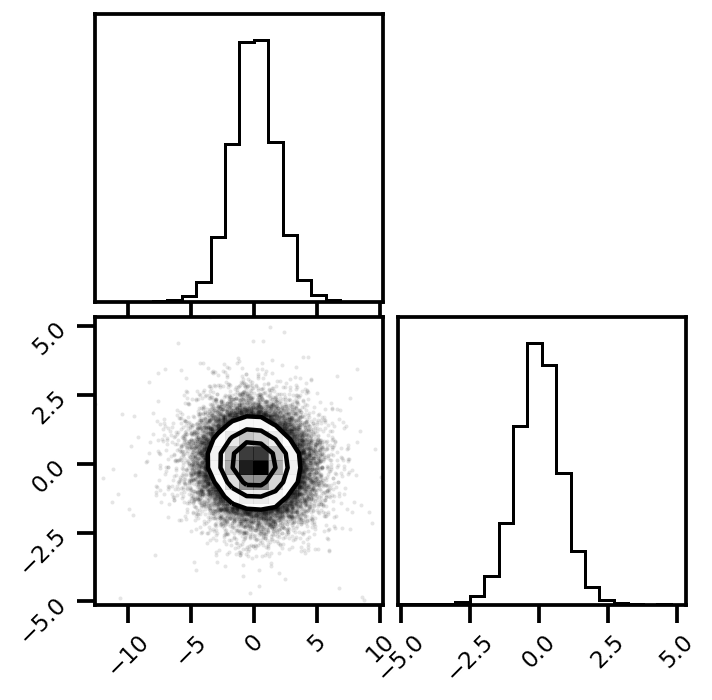

In [45]:
fig = corner.corner(res_tuple.X[:, :10])

#### Estimators

In [46]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 3.2423 | Time: 0.0037 secs
KNN (Neighbours): 3.2160  | Time: 0.2511 secs
KNN (epsilon): 2.7422 | Time: 0.2519 secs


#### Entropy

$$
\begin{aligned}
H(D,\nu, \mathbf{A}) &= \frac{1}{2}\log \left|\mathbf{A} \right| \\
&+ \log \left[ \frac{(\nu \pi)^{\frac{D}{2}}}{\Gamma\left( -\frac{D}{2} \right)}  \beta \left( \frac{D}{2},\frac{\nu}{2} \right)\right] \\
&+ \frac{\nu + D}{2} \left[ \psi\left( \frac{\nu + D}{2} \right)-\psi\left( \frac{\nu}{2} \right) \right]
\end{aligned}
$$

In [32]:
from pysim.information.gaussian import gaussian_entropy_symmetric
from pysim.information.studentt import studentt_entropy_symmetric
from scipy.stats import multivariate_normal

In [33]:
from scipy.special import gamma as Γ, psi as ψ, beta as β
from numpy import log, pi as π


def studentt_entropy_symmetric(df: float, cov: np.ndarray) -> float:
    """Entropy for Multivariate T-Student
    In this case, we are only considering the degrees
    of freedom (df) to be greater than 2.
    
    Parameters
    ----------
    df : float
        the degrees of freedom for the t-student
        (must be greater than 2)
    
    cov : np.ndarray
        the covariance matrix for the t-student distribution.
        (n_features, n_features)
        
    Returns
    -------
    H : float
        the differential entropy (nats)
    
    Resources
    ---------
    [1] :   A measure of total variability for the 
            multivariate t distribution with applications to 
            finance - Guerrero-Cusumano (1996)
            (equation 8)
    """

    assert df > 2
    ν = df
    Σ = cov

    assert Σ.shape[0] == Σ.shape[1]
    D = cov.shape[0]

    # Term I - change of variables
    term_a = 0.5 * np.linalg.slogdet(Σ)[1]

    # Term II
    term_b1 = ((ν - 2) * π) ** (0.5 * D)
    term_b2 = Γ(0.5 * D)
    term_b3 = β(0.5 * D, 0.5 * ν)
    term_b = log((term_b1 / term_b2) * term_b3)

    # Term III
    term_c = ψ(0.5 * (ν + D)) - ψ(0.5 * ν)
    term_c *= (ν + D) / 2.0

    # final term
    final_term = term_a + term_b + term_c

    return final_term

In [21]:
studentt_entropy_symmetric(df=df, cov=res_tuple.C)

2.590673313992948